In [1]:
from PaperTennis_env import PaperTennis2AgentEnv, PaperTennisEnv
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import time
# import pickle
from tqdm import tqdm

In [2]:
# Get action e-greedy
def get_action(state,Q_val,epsilon=0.1):
    if state[1] == 0:
        return 0

    p_epsilon = np.random.uniform(0,1)
    if p_epsilon < E_GREEDY:
        return np.argmax(np.random.uniform(0,1,(1,state[1]))) + 1

    q_s = np.zeros(state[1])

    for i in range(1,state[1]):
        q_s[i] = Q_val[state[0],state[1],state[2],i]

    return np.argmax(q_s) + 1

# Decay e on schedule
def e_decay(episode,rand_ep, min_e=0.1,max_e=0.5):
    return max(min_e, min(max_e, rand_ep / (episode + 1)))



In [39]:
#Hyperparms
NUM_EPISODES = 300000

E_GREEDY = 0.2

DECAY = False

GAMMA = 0.9
ALPHA = 0.1

# Get Strategy index
STRATEGY = 'Long'
Strategies = {
    'Mean': 1,
    'Long': 2,
    'Short': 3,
    'Naive': 4,
    'Random': 5
}

# Generate opponent strategy vector
if Strategies[STRATEGY] == 5:
    OPP_Strat = np.around(np.random.uniform(1,4,int(NUM_EPISODES/OPP_FREQ)))
    OPP_Strat = np.repeat(OPP_Strat, OPP_FREQ)
else: 
    OPP_Strat = np.repeat(Strategies[STRATEGY], NUM_EPISODES)


## Train
start_time = time.time()

# Init Q table and train history
Q_val = np.zeros([5,51,51,50])
train_episodes = 0

# Init Env
env = PaperTennisEnv()

# Plotting Stuff
rewards = np.zeros(NUM_EPISODES*3)
epsilons = np.zeros(NUM_EPISODES*3)


#Playing opponent
for episode in tqdm(range(NUM_EPISODES)):

    state = env.reset(opponent_strategy=OPP_Strat[episode])
    state_2 = (state[0],state[2],state[1])
    done = False

    if DECAY: epsilon = e_decay(episode,RAND_EP, MIN_E,MAX_E)
    else: epsilon = E_GREEDY

    action = get_action(state,Q_val,epsilon)
    action2 = get_action(state_2,Q_val,epsilon)

    # Generate an episode
    error_episode = 0
    while not done:
        # Step Environment
        state_prime, reward, done, _ = env.step(action)
        state_prime_2 = (state_prime[0],state_prime[2],state_prime[1])

        # Get Action e-greedy 
        action_prime = get_action(state_prime,Q_val,epsilon)
        action_prime_2 = get_action(state_prime_2,Q_val,epsilon)
        
        # SARSA tabular update (Section 6.5 S.B., psuedocode)
        # TD_error = (reward - GAMMA * Q_val[state_prime_2[0],state_prime_2[1],state_prime_2[2],action_prime_2-1]
        #     -Q_val[state_2[0],state_2[1],state_2[2],action2-1])

        # Q_val[state[0],state[1],state[2],action-1] = Q_val[state[0],state[1],state[2],action-1] - ALPHA*TD_error


        TD_error = (reward + GAMMA * Q_val[state_prime[0],state_prime[1],state_prime[2],action_prime-1]
            -Q_val[state[0],state[1],state[2],action-1])

        Q_val[state[0],state[1],state[2],action-1] = Q_val[state[0],state[1],state[2],action-1] + ALPHA*TD_error

        state  = state_prime
        state_2  = state_prime_2
        action = action_prime
        action2 = action_prime_2

    rewards[episode] = reward
    epsilons[episode] = epsilon
    if reward != 0: wins[episode] = 1
    if reward == 0: draws[episode] = 1


100%|██████████| 300000/300000 [01:43<00:00, 2910.63it/s]


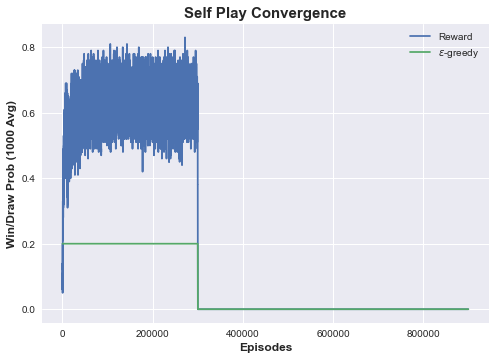

In [40]:
reward100 = np.flip(np.convolve(np.flip(np.maximum(rewards,0)), np.ones(100), mode='valid')/100)
plt.plot(reward100)
plt.plot(epsilons)
plt.title('Self Play Convergence'.format(1000),fontweight='bold',fontsize = 15)
plt.xlabel('Episodes',fontweight='bold',fontsize = 12)
plt.ylabel('Win/Draw Prob (1000 Avg)',fontweight='bold',fontsize = 12)
plt.legend(['Reward',r'$\epsilon$-greedy'])

100%|█████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.34it/s]


(0.0, 100.0)

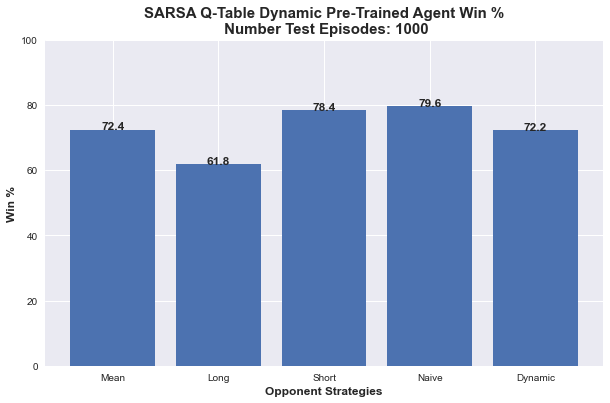

In [41]:
test_wins = np.zeros((5,1000))

env = PaperTennisEnv()

# Run Through Strategies
for opp_strategy in tqdm(range(1,6),ncols=100):

    if opp_strategy < 5: OPP_Strat = np.repeat(opp_strategy, 1000)
    else: OPP_Strat = np.random.randint(1,5,1000)

    for episode in range(1000):
        state = env.reset(OPP_Strat[episode])
        done = False
        while not done:
            action = get_action(state,Q_val,0)
            state, reward, done, _ = env.step(action)

        test_wins[opp_strategy-1,episode] = int(reward > 0)

test_win_percent = np.around(np.count_nonzero(test_wins,axis=1)/1000 * 100,2)

xlabels = ['Mean','Long','Short','Naive','Dynamic']

fig2,ax4 = plt.subplots(1,1,figsize=(10,6))
ax4.bar(xlabels,test_win_percent)
ax4.set_title('SARSA Q-Table Dynamic Pre-Trained Agent Win %\n Number Test Episodes: {}'.format(1000),fontweight='bold',fontsize = 15)
ax4.set_xlabel('Opponent Strategies',fontweight='bold',fontsize = 12)
ax4.set_ylabel('Win %',fontweight='bold',fontsize = 12)
for i,y in enumerate(test_win_percent):
        ax4.text(i, y, y, ha = 'center',fontweight='bold',fontsize = 12)

ax4.set_ylim([0,100])

In [42]:
wins = np.zeros(NUM_EPISODES*2)
draws = np.zeros(NUM_EPISODES*2)
env = PaperTennis2AgentEnv()

DECAY = True
MIN_E = 0.2
MAX_E = 1
RAND_EP = 150000

for episode in tqdm(range(NUM_EPISODES*2)):

    state = env.reset()
    state_2 = (state[0],state[2],state[1])
    done = False

    if DECAY: epsilon = e_decay(episode,RAND_EP, MIN_E,MAX_E)
    else: epsilon = E_GREEDY

    action = get_action(state,Q_val,epsilon)
    action2 = get_action(state_2,Q_val,epsilon)

    # Generate an episode
    while not done:
        # Step Environment
        state_prime, reward, done, _ = env.step(action,action2)
        state_prime_2 = (state_prime[0],state_prime[2],state_prime[1])

        # Get Action e-greedy 
        action_prime = get_action(state_prime,Q_val,epsilon)
        action_prime_2 = get_action(state_prime_2,Q_val,epsilon)
        
        # SARSA tabular update (Section 6.5 S.B., psuedocode)
        TD_error = (reward + GAMMA * Q_val[state_prime[0],state_prime[1],state_prime[2],action_prime-1]
            -Q_val[state[0],state[1],state[2],action-1])

        Q_val[state[0],state[1],state[2],action-1] = Q_val[state[0],state[1],state[2],action-1] + ALPHA*TD_error

        if state != state_2:
            TD_error = (reward + GAMMA * Q_val[state_prime_2[0],state_prime_2[1],state_prime_2[2],action_prime_2-1]
                -Q_val[state_2[0],state_2[1],state_2[2],action2-1])

            Q_val[state_2[0],state_2[1],state_2[2],action2-1] = Q_val[state_2[0],state_2[1],state_2[2],action2-1] + ALPHA*TD_error

        state  = state_prime
        state_2  = state_prime_2
        action = action_prime
        action2 = action_prime_2

    rewards[NUM_EPISODES+episode] = reward
    epsilons[NUM_EPISODES+episode] = epsilon
    if reward != 0: wins[episode] = 1
    if reward == 0: draws[episode] = 1

100%|██████████| 600000/600000 [03:14<00:00, 3081.48it/s]


/Users/sunaybhat/miniconda3/envs/py36_ML/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


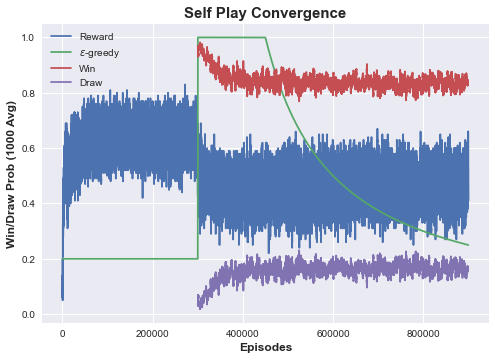

In [43]:
win1000 = np.flip(np.convolve(np.flip(wins), np.ones(1000), mode='valid')/1000)
draw1000 = np.flip(np.convolve(np.flip(draws), np.ones(1000), mode='valid')/1000)

reward100 = np.flip(np.convolve(np.flip(np.maximum(rewards,0)), np.ones(100), mode='valid')/100)
plt.plot(reward100)
plt.plot(epsilons)
plt.plot(range(NUM_EPISODES,NUM_EPISODES*3-999),win1000)
plt.plot(range(NUM_EPISODES,NUM_EPISODES*3-999),draw1000)
plt.title('Self Play Convergence'.format(1000),fontweight='bold',fontsize = 15)
plt.xlabel('Episodes',fontweight='bold',fontsize = 12)
plt.ylabel('Win/Draw Prob (1000 Avg)',fontweight='bold',fontsize = 12)
plt.legend(['Reward',r'$\epsilon$-greedy','Win','Draw'])

100%|█████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.12it/s]


(0.0, 100.0)

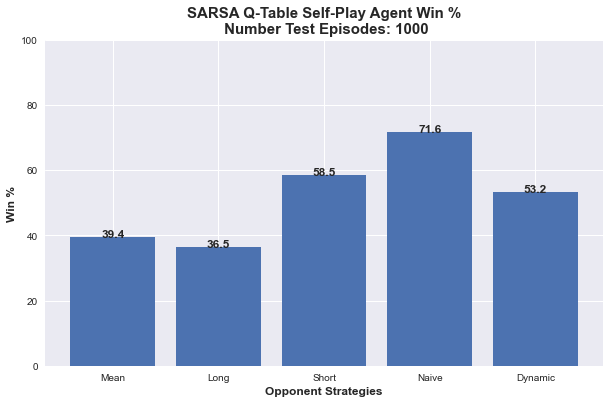

In [37]:
test_wins = np.zeros((5,1000))

env = PaperTennisEnv()

# Run Through Strategies
for opp_strategy in tqdm(range(1,6),ncols=100):

    if opp_strategy < 5: OPP_Strat = np.repeat(opp_strategy, 1000)
    else: OPP_Strat = np.random.randint(1,5,1000)

    for episode in range(1000):
        state = env.reset(OPP_Strat[episode])
        done = False
        while not done:
            action = get_action(state,Q_val,0)
            state, reward, done, _ = env.step(action)

        test_wins[opp_strategy-1,episode] = int(reward > 0)

test_win_percent = np.around(np.count_nonzero(test_wins,axis=1)/1000 * 100,2)

xlabels = ['Mean','Long','Short','Naive','Dynamic']

fig2,ax4 = plt.subplots(1,1,figsize=(10,6))
ax4.bar(xlabels,test_win_percent)
ax4.set_title('SARSA Q-Table Self-Play Agent Win %\n Number Test Episodes: {}'.format(1000),fontweight='bold',fontsize = 15)
ax4.set_xlabel('Opponent Strategies',fontweight='bold',fontsize = 12)
ax4.set_ylabel('Win %',fontweight='bold',fontsize = 12)
for i,y in enumerate(test_win_percent):
        ax4.text(i, y, y, ha = 'center',fontweight='bold',fontsize = 12)

ax4.set_ylim([0,100])